In [1]:
import scipy.sparse as spp
import numpy as np

In [10]:
grid_size_z = 1024
domain_AR = 0.5
dx = 1.0 / grid_size_z
grid_size_r = int(domain_AR * grid_size_z)
z = np.linspace(0.5 * dx, 1 - 0.5 * dx, grid_size_z)
r = np.linspace(0.5 * dx, domain_AR - 0.5 * dx, grid_size_r)
Z, R = np.meshgrid(z, r)
R_diag = spp.diags((R ** -1).reshape(-1, ), format='csc')
A_zz = spp.diags([1, -2, 1], [-1, 0, 1], 
                shape=(grid_size_z, grid_size_z), format='csc') / (dx ** 2)
A_rr = spp.diags([1, -2, 1], [-1, 0, 1], 
                shape=(grid_size_r, grid_size_r), format='csc') / (dx ** 2)

A_zz[0, 1] *= 2.0
A_zz[-1, -2] *= 2.0
A_rr[-1, -2] *= 2.0

# A_zz[0, 0] = 2.0 / (dx ** 2)
# A_zz[0, 1] = -5.0 / (dx ** 2)
# A_zz[0, 2] = 4.0 / (dx ** 2)
# A_zz[0, 3] = -1.0 / (dx ** 2)
# A_zz[-1, 0] = 2.0 / (dx ** 2)
# A_zz[-1, 1] = -5.0 / (dx ** 2)
# A_zz[-1, 2] = 4.0 / (dx ** 2)
# A_zz[1, 3] = -1.0 / (dx ** 2)
# A_rr[-1, -1] = 1.0 / (dx ** 2)
# A_rr[-1, -2] = -2.0 / (dx ** 2)
# A_rr[-1, -3] = 1.0 / (dx ** 2)

A_r = spp.diags([-1, 1], [-1, 1], 
                shape=(grid_size_r, grid_size_r), format='csc') / (2 * dx)
A_r[-1, -2] = 0.0

# A_r[-1, -1] = 1.0 / dx
# A_r[-1, -2] = -1.0 / dx

Idz = spp.identity(grid_size_z)
Idr = spp.identity(grid_size_r)
Id1 = spp.diags(np.repeat(1.0, grid_size_r), format='csc')
Id1[0, 0] = 0.0
mask_Id = spp.kron(Id1,Idz)
Id2 = spp.diags(np.repeat(0.0, grid_size_r), format='csc')
Id2[0, 0] = 1.0
unmask_Id = spp.kron(Id2, Idz)
Id3 = spp.diags(np.repeat(1.0, grid_size_r), format="csc")
Id3[-1, -1] = 0.0

# A_r[0, 1] = 0.0
# A_rr[0, 1] *= 2.0

# Idz = spp.identity(grid_size_z)
# Idr = spp.identity(grid_size_r)
# Id1 = spp.diags(np.repeat(1.0, grid_size_r), format='csc')
# Id1[-1, -1] = 0.0
# mask_Id = spp.kron(Id1,Idz)
# Id2 = spp.diags(np.repeat(0.0, grid_size_r), format='csc')
# Id2[-1, -1] = 1.0
# unmask_Id = spp.kron(Id2, Idz)
# Id3 = spp.diags(np.repeat(1.0, grid_size_r), format="csc")
# Id3[0, -0] = 0.0

/usr/local/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [11]:
A_final = mask_Id * (spp.kron(A_rr, Idz) + spp.kron(Id3, A_zz) - R_diag * spp.kron(A_r, Idz)) + unmask_Id / (dx ** 2)
#A_final = mask_Id * (spp.kron(A_rr, Idz) + spp.kron(Id3, A_zz) + R_diag * spp.kron(A_r, Idz)) + unmask_Id / (dx ** 2)
print(A_final.toarray())
import numpy.linalg as la
# print(la.cond(A_final.toarray()))

[[ 1048576.        0.        0. ...        0.        0.        0.]
 [       0.  1048576.        0. ...        0.        0.        0.]
 [       0.        0.  1048576. ...        0.        0.        0.]
 ...
 [       0.        0.        0. ... -2097152.        0.        0.]
 [       0.        0.        0. ...        0. -2097152.        0.]
 [       0.        0.        0. ...        0.        0. -2097152.]]


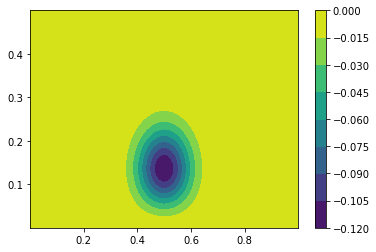

In [12]:
import scipy.sparse.linalg as sppla
import matplotlib.pyplot as plt
#vort = np.sin(np.pi * R)
vort = np.exp(-((R - 0.1) ** 2 + (Z - 0.5) ** 2) / 0.01)
plt.contourf(Z, R, -R * vort)
plt.colorbar()
b = (-R * vort).reshape(-1, )

0.6620168685913086


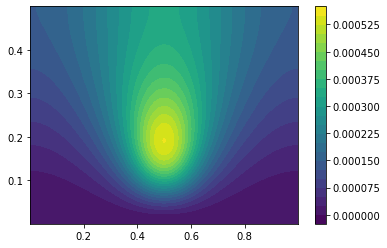

In [13]:
#A_inv = sppla.inv(A_final)
#psi = A_inv * b
# M2 = sppla.spilu(A_final)
# M = sppla.LinearOperator((grid_size_z * grid_size_r, grid_size_z * grid_size_r), M2.solve)

LU = sppla.splu(A_final)

psi = 0 * b
#psi[...], code = sppla.gmres(A_final, b, x0=psi, M=M)
import time
s = time.time()
psi[...] = LU.solve(b)
e = time.time()
print(e - s)
# A_inv = sppla.inv(A_final)
# psi = A_inv * b
#plt.contour(Z, R, psi.reshape(grid_size_r, -1), levels=50)
plt.contourf(Z, R, psi.reshape(grid_size_r, -1), levels=25)
plt.colorbar()
#print(code)

In [15]:
%timeit LU.solve(b)

167 ms ± 47.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
